# GWAS Analysis

I want to see whether the eQTLs are enriched for GWAS hits. I've taken GWAS results
used in the Roadmap project and in the grasp database and I've filtered out any 
hits that have $p > 10^{-5}$. Then I LD pruned and expanded the hits and made sets
of null SNPs matched for TSS distance, MAF, and number of LD neighbors. I want
to do a Fisher test of whether a given GWAS hit or null variant is also an eQTL.
I'll do the counting according to the independent variants (e.g. if a signal GWAS
hit is expanded into 10 variants and two of those 10 variants overlap eQTL variants,
I'll only count this as one overlap).

In [2]:
import glob
import os
import random
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pybedtools as pbt
from scipy.stats import fisher_exact
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels as sms
import tabix

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

import socket
if socket.gethostname() == 'fl1':
    pbt.set_tempdir('/projects/cdeboever/pybedtools_temp')
    
outdir = os.path.join(ciepy.root, 'output',
                      'gwas_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'gwas_analysis')
cpy.makedir(private_outdir)

In [3]:
sns.set_style('white')

In [4]:
def calculate_overlap(eqtl_fn, gwas_fn):
    c = 'bedtools intersect -wb -a {} -b {} | cut -f 8 | sort | uniq | wc -l'.format(eqtl_fn, gwas_fn)
    count = int(subprocess.check_output(c, shell=True).strip())
    return eqtl_fn, gwas_fn, count

In [6]:
parallel_client = Client(profile='parallel')
dview = parallel_client[:]
print('Cluster has {} engines.'.format(len(parallel_client.ids)))

with dview.sync_imports():
    import subprocess

dview.push(dict(calculate_overlap=calculate_overlap));

Cluster has 250 engines.
importing subprocess on engine(s)


## GRASP database

In [7]:
grasp_phenos = pd.read_table('/publicdata/grasp2_20151104/variant_enrichment/grasp_phenotypes_500.tsv', 
                             index_col=0)
grasp_phenos.index = ['grasp_pheno_{}'.format(x) for x in grasp_phenos.index]

fns = glob.glob('/publicdata/grasp2_20151104/variant_enrichment/grasp_pheno_*/independent_snps.tsv')
num = []
for fn in fns:
    num.append(int(subprocess.check_output('wc -l {}'.format(fn), shell=True).strip().split()[0]))
    
grasp_phenos.ix[[x.split('/')[-2] for x in fns], 'number_independent'] = num

grasp_phenos_f = grasp_phenos[grasp_phenos.number_independent >= 200]

In [ ]:
fn = os.path.join(outdir, 'grasp_counts.tsv')
if not os.path.exists(fn):
    num_null = 1000
    eqtl_bed = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'sig_snv_independent.bed')

    bed_pairs = []
    for i in grasp_phenos_f.index:
        bed_pairs.append([eqtl_bed, ('/publicdata/grasp2_20151104/variant_enrichment/{}/'
                                     'independent_with_null_expanded.bed'.format(i))])
        for j in range(num_null):
            bed_pairs.append([eqtl_bed, ('/publicdata/grasp2_20151104/variant_enrichment/{}/'
                                     'null_sets_expanded/null_{}_expanded.bed'.format(i, j))])
    res = dview.map_sync(lambda x: calculate_overlap(x[0], x[1]),
                         bed_pairs)
    grasp_counts = pd.DataFrame(np.nan, index=grasp_phenos_f.index, 
                                columns=['real'] + ['null_{}'.format(i) for i in range(num_null)])
    for r in res:
        if os.path.split(r[1])[1] == 'independent_with_null_expanded.bed':
            grasp_counts.ix[r[1].split('/')[-2], 'real'] = r[2]
        else:
            col = '_'.join(os.path.split(r[1])[1].split('_')[0:2])
            grasp_counts.ix[r[1].split('/')[-3], col] = r[2]
    grasp_counts.to_csv(fn, sep='\t')
else:
    grasp_counts = pd.read_table(fn, index_col=0)

In [ ]:
fn = os.path.join(outdir, 'grasp_results.tsv')
if not os.path.exists(fn):
    n = 50
    g_odds = []
    g_pvals = []
    for i in grasp_phenos_f.index:
        total = grasp_phenos_f.ix[i, 'number_independent']
        real_not_overlap = total - grasp_counts.ix[i, 'real']
        real_overlap = grasp_counts.ix[i, 'real']
        null_overlap = grasp_counts.ix[i, ['null_{}'.format(x) for x in range(n)]].sum()
        null_not_overlap = total * n - null_overlap
        odds,pval = fisher_exact([[real_overlap, real_not_overlap], 
                                  [null_overlap, null_not_overlap]])
        g_odds.append(odds)
        g_pvals.append(pval)
    grasp_phenos_f['odds'] = g_odds
    grasp_phenos_f['pvalue'] = g_pvals
    r = sms.sandbox.stats.multicomp.multipletests(grasp_phenos_f.pvalue, method='fdr_bh')
    grasp_phenos_f['bh_pvalue'] = r[1]
    grasp_phenos_f['bh_sig'] = r[0]
    grasp_phenos_f.to_csv(fn, sep='\t')
else:
    grasp_phenos_f = pd.read_table(fn, index_col=0)

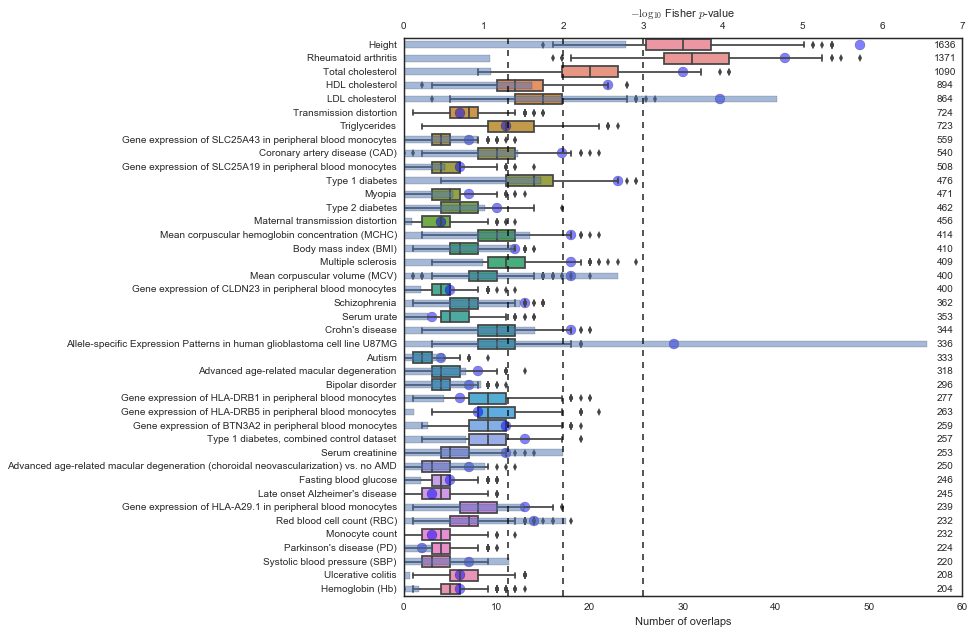

In [30]:
se = grasp_phenos_f.number_independent.copy(deep=True)
se.sort_values(ascending=False, inplace=True)

fig,ax = plt.subplots(1, 1, figsize=(10, 10))

sns.boxplot(data=grasp_counts.ix[se.index, grasp_counts.columns[1:]].T, ax=ax, orient='h')
ax.scatter(grasp_counts.ix[se.index, 'real'], range(grasp_phenos_f.shape[0]), alpha=0.5, s=100)

xmin, xmax = ax.get_xlim()
for i in range(se.shape[0]):
    ax.text(0.97 * xmax, i, se.values[i], va='center', ha='center')
ax.set_xlabel('Number of overlaps')
ax.set_xlim(0, xmax)
ymin,ymax = ax.get_ylim()

ax2 = ax.twiny()
ax2.set_xlabel('$-\log_{10}$ Fisher $p$-value')
h = 0.5
step = abs(ymax - ymin) / se.shape[0]
b = np.arange(ymax, ymin, step) + (step / 2 - h / 2)
ax2.barh(b, -np.log10(grasp_phenos_f.ix[se.index, 'pvalue']), height=h, alpha=0.5)
ax.set_ylim(ymin, ymax)
ax2.vlines(-np.log10(0.05), ymin, ymax, linestyle='--', alpha=0.75)
ax2.vlines(-np.log10(0.01), ymin, ymax, linestyle='--', alpha=0.75)
ax2.vlines(-np.log10(0.001), ymin, ymax, linestyle='--', alpha=0.75)
ax2.set_yticklabels(grasp_phenos.ix[se.index, 'phenotype']);

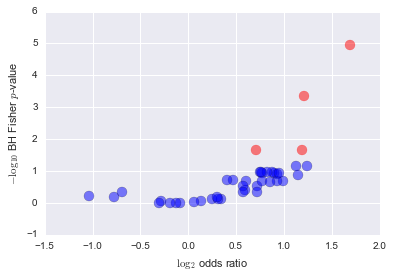

In [34]:
with sns.axes_style('darkgrid'):
    se = grasp_phenos_f[grasp_phenos_f.bh_sig]
    plt.scatter(np.log2(se.odds), -np.log10(se.bh_pvalue), color='red', s=100, alpha=0.5)
    se = grasp_phenos_f[grasp_phenos_f.bh_sig == False]
    plt.scatter(np.log2(se.odds), -np.log10(se.bh_pvalue), s=100, alpha=0.5)
    plt.ylabel('$-\log_{10} $ BH Fisher $p$-value')
    plt.xlabel('$\log_{2} $ odds ratio');

## Roadmap GWAS

In [ ]:
dys = glob.glob('/frazer01/publicdata/roadmap_gwas_20151104/variant_enrichment/EUR.*')

In [ ]:
roadmap_phenos = pd.DataFrame([os.path.split(x)[1] for x in dys], columns=['name'],
                              index=[os.path.split(x)[1] for x in dys])
roadmap_phenos['phenotype'] = roadmap_phenos.name.apply(lambda x: x[4:])
roadmap_phenos['phenotype'] = roadmap_phenos.phenotype.apply(
    lambda x: x.replace('Randall2013PlosGenet_stage1_publicrelease_HapMapCeuFreq_', ''))
roadmap_phenos['phenotype'] = roadmap_phenos.phenotype.apply(
    lambda x: x.replace('Yang2012Nature_publicrelease_HapMapCeuFreq_', ''))
roadmap_phenos['phenotype'] = roadmap_phenos.phenotype.apply(
    lambda x: x.replace('Manning_et_al_', ''))
roadmap_phenos['phenotype'] = roadmap_phenos.phenotype.apply(
    lambda x: x.replace('Speliotes2010_publicrelease_HapMapCeuFreq_', ''))
roadmap_phenos['phenotype'] = roadmap_phenos.phenotype.apply(
    lambda x: x.replace('LangoAllen2010_publicrelease_HapMapCeuFreq_', ''))
roadmap_phenos['phenotype'] = roadmap_phenos.phenotype.apply(
    lambda x: x.replace('Heid2010_publicrelease_HapMapCeuFreq_', ''))

In [ ]:
fns = glob.glob('/publicdata/roadmap_gwas_20151104/variant_enrichment/EUR.*/independent_snps.tsv')
num = []
for fn in fns:
    num.append(int(subprocess.check_output('wc -l {}'.format(fn), shell=True).strip().split()[0]))
    
roadmap_phenos.ix[[x.split('/')[-2] for x in fns], 'number_independent'] = num

roadmap_phenos_f = roadmap_phenos[roadmap_phenos.number_independent >= 200]

In [ ]:
fn = os.path.join(outdir, 'roadmap_counts.tsv')
if not os.path.exists(fn):
    num_null = 1000
    eqtl_bed = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'sig_snv_independent.bed')
    bed_pairs = []
    for i in roadmap_phenos_f.index:
        bed_pairs.append([eqtl_bed, ('/publicdata/roadmap_gwas_20151104/variant_enrichment/{}/'
                                     'independent_with_null_expanded.bed'.format(i))])
        for j in range(num_null):
            bed_pairs.append([eqtl_bed, ('/publicdata/roadmap_gwas_20151104/variant_enrichment/{}/'
                                     'null_sets_expanded/null_{}_expanded.bed'.format(i, j))])
    res = dview.map_sync(lambda x: calculate_overlap(x[0], x[1]),
                         bed_pairs)
    roadmap_counts = pd.DataFrame(np.nan, index=roadmap_phenos_f.index, 
                                columns=['real'] + ['null_{}'.format(i) for i in range(num_null)])
    for r in res:
        if os.path.split(r[1])[1] == 'independent_with_null_expanded.bed':
            roadmap_counts.ix[r[1].split('/')[-2], 'real'] = r[2]
        else:
            col = '_'.join(os.path.split(r[1])[1].split('_')[0:2])
            roadmap_counts.ix[r[1].split('/')[-3], col] = r[2]
    roadmap_counts.to_csv(fn, sep='\t')
else:
    roadmap_counts = pd.read_table(fn, index_col=0)

In [ ]:
fn = os.path.join(outdir, 'roadmap_results.tsv')
if not os.path.exists(fn):
    n = 50
    g_odds = []
    g_pvals = []
    for i in roadmap_phenos_f.index:
        total = roadmap_phenos_f.ix[i, 'number_independent']
        real_not_overlap = total - roadmap_counts.ix[i, 'real']
        real_overlap = roadmap_counts.ix[i, 'real']
        null_overlap = roadmap_counts.ix[i, ['null_{}'.format(x) for x in range(n)]].sum()
        null_not_overlap = total * n - null_overlap
        odds,pval = fisher_exact([[real_overlap, real_not_overlap], 
                                  [null_overlap, null_not_overlap]])
        g_odds.append(odds)
        g_pvals.append(pval)
    roadmap_phenos_f['odds'] = g_odds
    roadmap_phenos_f['pvalue'] = g_pvals
    r = sms.sandbox.stats.multicomp.multipletests(roadmap_phenos_f.pvalue, method='fdr_bh')
    roadmap_phenos_f['bh_pvalue'] = r[1]
    roadmap_phenos_f['bh_sig'] = r[0]
    roadmap_phenos_f.to_csv(fn, sep='\t')
else:
    roadmap_phenos_f = pd.read_table(fn, index_col=0)

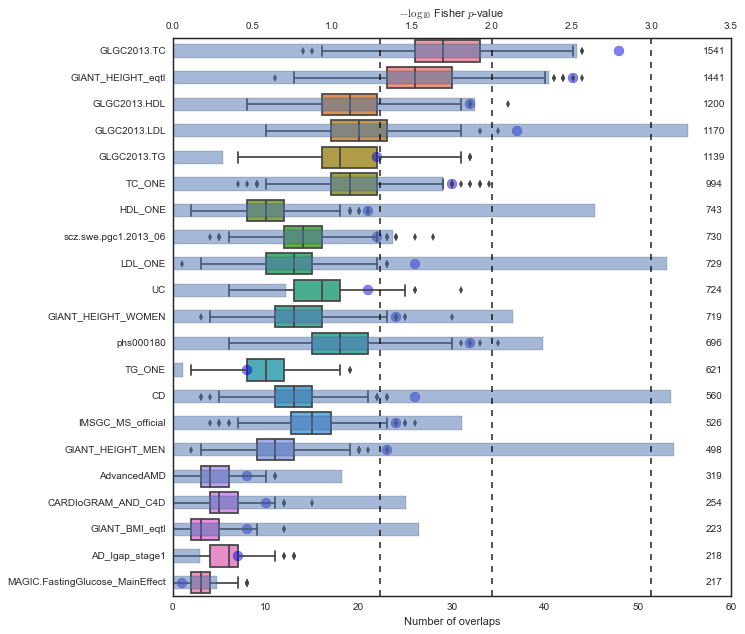

In [31]:
se = roadmap_phenos_f.number_independent.copy(deep=True)
se.sort_values(ascending=False, inplace=True)

fig,ax = plt.subplots(1, 1, figsize=(10, 10))

sns.boxplot(data=roadmap_counts.ix[se.index, roadmap_counts.columns[1:]].T, ax=ax, orient='h')
ax.scatter(roadmap_counts.ix[se.index, 'real'], range(roadmap_counts.shape[0]), alpha=0.5, s=100)

xmin, xmax = ax.get_xlim()
for i in range(se.shape[0]):
    ax.text(0.97 * xmax, i, se.values[i], va='center', ha='center')
ax.set_xlabel('Number of overlaps')
ax.set_xlim(0, xmax)
ymin,ymax = ax.get_ylim()

ax2 = ax.twiny()
ax2.set_xlabel('$-\log_{10}$ Fisher $p$-value')
h = 0.5
step = abs(ymax - ymin) / se.shape[0]
b = np.arange(ymax, ymin, step) + (step / 2 - h / 2)
ax2.barh(b, -np.log10(roadmap_phenos_f.ix[se.index, 'pvalue']), height=h, alpha=0.5)
ax.set_ylim(ymin, ymax)
ax2.vlines(-np.log10(0.05), ymin, ymax, linestyle='--', alpha=0.75)
ax2.vlines(-np.log10(0.01), ymin, ymax, linestyle='--', alpha=0.75)
ax2.vlines(-np.log10(0.001), ymin, ymax, linestyle='--', alpha=0.75)
ax2.set_yticklabels(roadmap_phenos.ix[se.index, 'phenotype']);

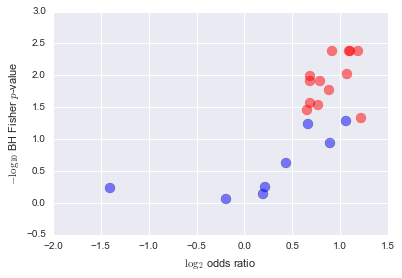

In [32]:
with sns.axes_style('darkgrid'):
    se = roadmap_phenos_f[roadmap_phenos_f.bh_sig]
    plt.scatter(np.log2(se.odds), -np.log10(se.bh_pvalue), color='red', s=100, alpha=0.5)
    se = roadmap_phenos_f[roadmap_phenos_f.bh_sig == False]
    plt.scatter(np.log2(se.odds), -np.log10(se.bh_pvalue), s=100, alpha=0.5)
    plt.ylabel('$-\log_{10} $ BH Fisher $p$-value')
    plt.xlabel('$\log_{2} $ odds ratio');

## Cancer Susceptibility GWAS

In [ ]:
out = os.path.join(outdir, 'cancer_gwas.tsv')
if not os.path.exists(out):
    !grep ancer /publicdata/grasp2_20151104/GRASP2fullDataset.tsv > {out}

In [ ]:
cancer = pd.read_table(out, low_memory=False)
cancer = cancer[cancer.Phenotype.apply(lambda x: 'Gene expression' not in x)]
cancer = cancer[cancer.Phenotype.apply(lambda x: 'IGP' not in x)]

In [ ]:
cancer_phenotypes = [
    'Neuroblastoma (brain cancer)',
    'Childhood acute lymphoblastic leukemia',
    'Prostate cancer',
    'Renal cell carcinoma (renal cancer)',
    'Multiple myeloma',
    'Lung cancer',
    'Colorectal cancer',
    'Cervical cancer',
    'Glioma',
    'Breast cancer (Estrogen receptor negative breast cancer)',
    'Lung cancer (adenocarcinoma)',
    'Urinary bladder cancer',
    'Non-Hodgkin lymphoma (Follicular lymphoma)',
    'Non-Hodgkin lymphoma (Diffuse large B-cell lymphoma)',
    'Esophageal squamous cell carcinoma (Esophageal cancer)',
    'Pancreatic cancer',
    'Classical Hodgkin\'s lymphoma',
    'Endometrial cancer',
    ]

In [ ]:
t = cancer[cancer.Phenotype.apply(lambda x: x in cancer_phenotypes)]
t.to_csv(os.path.join(outdir, 'cancer_gwas_filtered.tsv'), index=None, sep='\t')
tdf = cpb.analysis.parse_grasp_gwas(os.path.join(outdir, 'cancer_gwas_filtered.tsv'))

In [ ]:
ld_beds = glob.glob('/publicdata/1KGP_20151103/LD/tabix/'
                    'chr*_EUR_ld_all.hap.ld.bed.gz')
ld_beds = dict(zip([os.path.split(x)[1].split('_')[0] for x in ld_beds],
                   ld_beds))

In [ ]:
def get_snps():
    snpsnap_fns = glob.glob('/publicdata/SNPsnap_20151104/EUR_parse/*.tab')
    dfs = []
    for tab in snpsnap_fns:
        df = pd.read_table(tab, index_col=0, low_memory=False)
        tdf = df[['snp_maf', 'dist_nearest_gene_snpsnap_protein_coding',
                  'friends_ld08']]
        tdf.index = 'chr' + tdf.index
        dfs.append(tdf)
    snps = pd.concat(dfs)
    snps['maf_bin'] = pd.cut(snps.snp_maf, np.arange(0, 0.55, 0.05))
    snps['ld_bin'] = pd.cut(np.log10(snps.friends_ld08.replace(np.nan, 0) + 1), 10)
    snps['dist_bin'] = pd.cut(np.log10(snps.dist_nearest_gene_snpsnap_protein_coding
                                       + 1), 10)
    snps = snps[['maf_bin', 'ld_bin', 'dist_bin']]
    return snps

In [ ]:
snps_retrieved = False
fn = os.path.join(outdir, 'cancer_gwas_independent.tsv')
if not os.path.exists(fn):
    if not snps_retrieved:
        snps = get_snps()
        snps_retrieved = True
    pruned = cpb.analysis.ld_prune(tdf, ld_beds, snvs=list(snps.index))
    pruned.to_csv(fn, sep='\t')
else:
    pruned = pd.read_table(fn, index_col=0)

In [ ]:
fn = os.path.join(outdir, 'cancer_gwas_null_snps.tsv')
if not os.path.exists(fn):
    if not snps_retrieved:
        snps = get_snps()
        snps_retrieved = True
    nulls = cpb.analysis.generate_null_snvs(snps, pruned.index, num_null_sets=1000)
    nulls.to_csv(fn, sep='\t')
else:
    nulls = pd.read_table(fn, index_col=0)

In [ ]:
fn = os.path.join(outdir, 'cancer_gwas_independent_ld_expanded.bed')
if not os.path.exists(fn):
    tdf = pruned.ix[nulls['input']]
    expanded_bt = cpb.analysis.ld_expand(tdf, ld_beds)
    expanded_bt.saveas(fn)
else:
    expanded_bt = pbt.BedTool(fn)

In [ ]:
null_dy = os.path.join(outdir, 'cancer_gwas_nulls_expanded')
if not os.path.exists(null_dy):
    cpy.makedir(null_dy)
    tdf = nulls.drop('input', axis=1)
    for c in tdf.columns:
        se = nulls[c]
        chrom = se.apply(lambda x: x.split(':')[0])
        end = se.apply(lambda x: int(x.split(':')[1]))
        start = end - 1
        rsid = se.values
        df = pd.DataFrame({'chrom':chrom.values, 'start':start.values,
                           'end':end.values, 'rsid':se.values, 'pvalue':1},
                          index=se.values)
        df = df[['chrom', 'start', 'end', 'rsid', 'pvalue']]
        bt = cpb.analysis.ld_expand(df, ld_beds)
        bt.saveas(os.path.join(null_dy, '{}_expanded.bed'.format(c)))

In [ ]:
fn = os.path.join(outdir, 'cancer_counts.tsv')
if not os.path.exists(fn):
    num_null = 1000
    eqtl_bed = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'sig_snv_independent.bed')
    bed_pairs = [[eqtl_bed, expanded_bt.fn]]
    for j in range(num_null):
        bed_pairs.append([eqtl_bed, os.path.join(outdir, null_dy, 'null_{}_expanded.bed'.format(j))])
    res = dview.map_sync(lambda x: calculate_overlap(x[0], x[1]),
                         bed_pairs)
    cancer_counts = [x[2] for x in res]
    cancer_counts = pd.Series(cancer_counts, index=['real'] + ['null_{}'.format(i) for i in range(num_null)])
    cancer_counts.to_csv(fn, sep='\t')
else:
    cancer_counts = pd.read_table(fn, index_col=0, header=None, squeeze=True)

In [33]:
n = 50
total = pruned.shape[0]
real_not_overlap = total - cancer_counts['real']
real_overlap = cancer_counts['real']
null_overlap = cancer_counts[['null_{}'.format(x) for x in range(n)]].sum()
null_not_overlap = total * n - null_overlap
odds,pval = fisher_exact([[real_overlap, real_not_overlap], 
                          [null_overlap, null_not_overlap]])
print(odds, pval)

(1.3654578044292691, 0.11579686791664599)
